## Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers6 import PlotROCCurve

In [2]:
output_path = 'C:\\Users\\joeta\\python_smu_mitb\\isss623_aha\\groupProject'
path = output_path
df_train = pd.read_csv((os.path.join(path, 'train2.csv')))
df_test = pd.read_csv((os.path.join(path, 'test2.csv')))
confidence_interval = 95
random_seed = 0

In [3]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime_ed,outtime_ed,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,race,edregtime,edouttime,insurance,in_year,age,before_ed_mortality,outcome_hospitalization,outcome_inhospital_mortality,ed_death,ed_los,intime_icu,outtime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,273532,18971123,21753872.0,37200982,2149-07-15 22:41:00,2149-07-16 06:27:00,45.0,F,2149.0,NaN,2149-07-16 04:10:00,2149-07-28 18:37:00,NaN,WHITE,2149-07-15 22:41:00,2149-07-16 06:27:00,Other,2149,45.0,False,True,False,False,0 days 07:46:00,NaN,NaN,NaN,False,False,0,1,1,2149-08-01 14:27:00,16 days 08:00:00,False,0,0,0,0,0,0,7.77,NaN,16.33,37.444444,102.0,19.0,100.0,133.0,88.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.333333,72.0,16.0,100.0,165.0,105.0,0.0,3.0,1.0,103.000000,0,0,2,1,1,2
1,253777,15439233,NaN,31867345,2159-12-20 19:43:00,2159-12-20 19:59:00,18.0,M,2159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,18.0,False,False,False,False,0 days 00:16:00,NaN,NaN,NaN,False,False,0,0,0,2160-02-11 01:14:00,52 days 05:15:00,False,0,0,0,0,0,0,0.27,NaN,52.22,37.111111,70.0,20.0,99.0,151.0,64.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.666667,60.0,16.0,100.0,132.0,70.0,7.0,1.0,0.0,93.000000,0,0,0,0,0,1
2,365291,15341533,NaN,30037900,2171-09-02 21:24:00,2171-09-02 21:27:00,40.0,F,2171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2171,40.0,False,False,False,False,0 days 00:03:00,NaN,NaN,NaN,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,0.05,NaN,NaN,37.555556,97.0,16.0,97.0,120.0,70.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.555556,95.0,18.0,98.0,113.0,67.0,0.0,0.0,0.0,86.666667,0,0,0,1,1,1
3,76261,13512582,NaN,38777853,2131-11-08 22:59:00,2131-11-08 23:04:00,70.0,F,2131.0,NaN,NaN,NaN,NaN,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,NaN,2131,70.0,False,False,False,False,0 days 00:05:00,NaN,NaN,NaN,False,False,0,0,0,2137-11-14 18:47:00,2197 days 19:43:00,False,0,0,0,0,0,0,0.08,NaN,2197.82,37.000000,58.0,16.0,100.0,155.0,44.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.111111,51.0,18.0,96.0,173.0,63.0,2.0,3.0,2.0,81.000000,3,13,7,0,0,1
4,99718,17758321,NaN,35942414,2115-06-25 13:15:00,2115-06-25 13:38:00,50.0,M,2115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2115,50.0,False,False,False,False,0 days 00:23:00,NaN,NaN,NaN,False,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,0.38,NaN,NaN,36.555556,72.0,16.0,96.0,187.0,108.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,62.0,16.0,100.0,161.0,99.0,0.0,1.0,2.0,134.333333,1,0,5,0,0,1


### 1. task-specific filter

In [4]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False].reset_index()

### 2. Variable Selection

In [5]:
variable = ["age", "gender",
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [ ]:
X_train.dtypes.to_frame().T

In [7]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [8]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.06275673965130121 : 1


### 3.  Modeling script

In [9]:
# Containers for all results
result_list = []

Logistic Regression:


C:\Users\joeta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.571864366531372 seconds
AUC: 0.8841257756650672
AUPRC: 0.4373697969214443
Sensitivity: 0.8063605570191946
Specificity: 0.7971464094733411
Score thresold: 0.0641021088179065
2.5 97.5


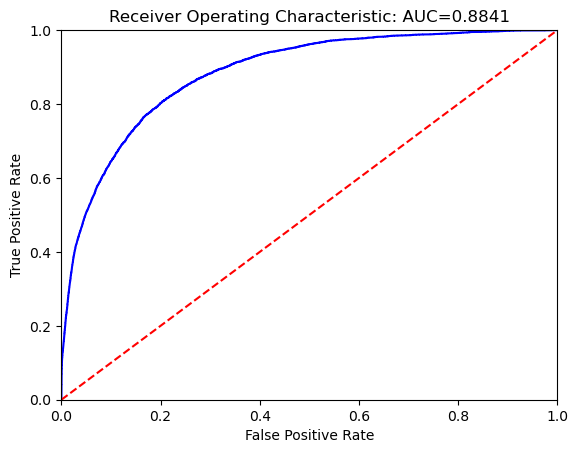

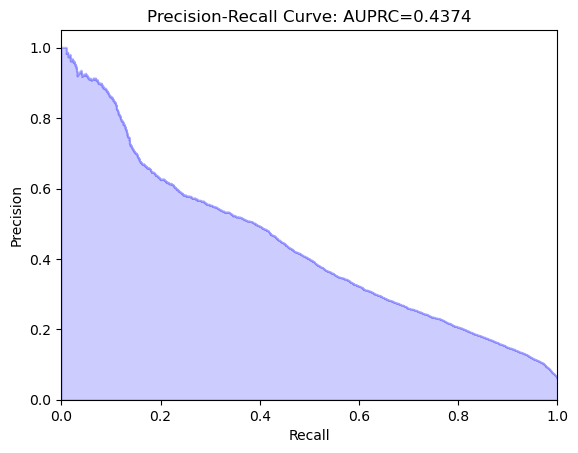

In [10]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 99.88601183891296 seconds
AUC: 0.8927292494646327
AUPRC: 0.5191172374705223
Sensitivity: 0.7995859992472714
Specificity: 0.8250908344700216
Score thresold: 0.08
2.5 97.5


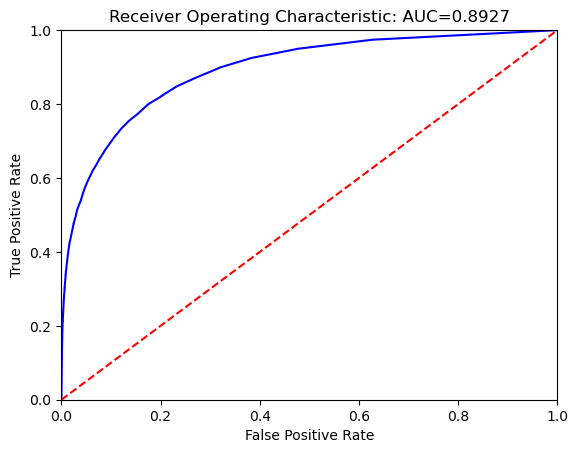

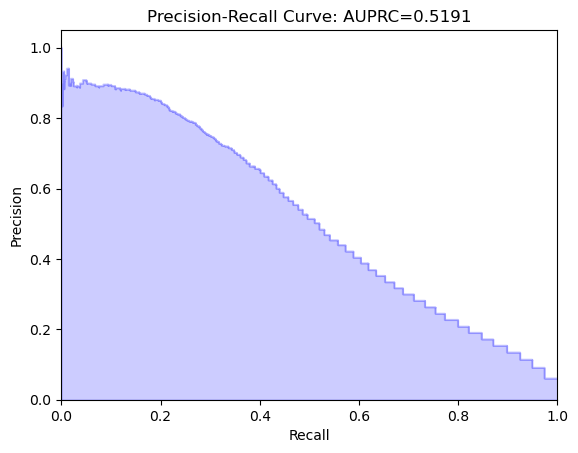

[0.09334362 0.0136141  0.00476209 0.00751626 0.01494395 0.00477482
 0.00770236 0.01339191 0.01368722 0.03203871 0.09400319 0.06990634
 0.08473737 0.04893118 0.04577221 0.08964639 0.07698255 0.03678368
 0.07992709 0.00549688 0.00551261 0.00362309 0.00136268 0.00213443
 0.00232677 0.00301105 0.0041475  0.0031638  0.00282697 0.00421124
 0.00462498 0.00404264 0.00401451 0.00225631 0.00603509 0.00222428
 0.00216016 0.00384333 0.00620671 0.00399618 0.00178703 0.00415337
 0.00426448 0.00227954 0.00318422 0.00091882 0.00590818 0.00382137
 0.00348467 0.00405106 0.00775623 0.00464069 0.00455419 0.00137089
 0.00417931 0.00460435 0.00351209 0.00585743 0.00162905 0.00362284
 0.00380141 0.0030523  0.00207635 0.00580384]


In [11]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 104.9854109287262 seconds
AUC: 0.9005317445924836
AUPRC: 0.5431431946348013
Sensitivity: 0.8138878434324426
Specificity: 0.8234008908417126
Score thresold: 0.06345402100147074
2.5 97.5


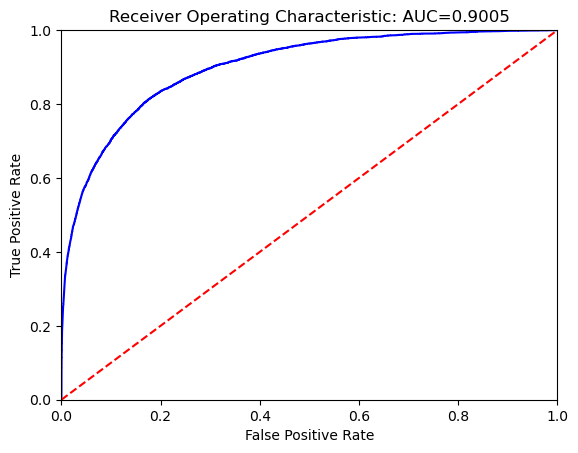

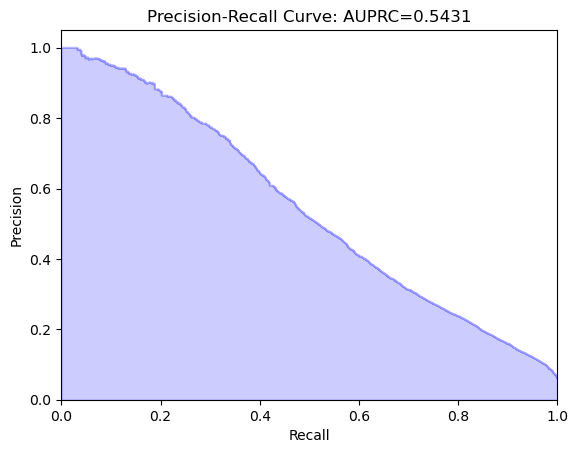

In [12]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [13]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [14]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp')

Epoch 1/20
1764/1764 [==============================] - 5s 2ms/step - loss: 0.2085 - accuracy: 0.9454 - auc: 0.8295 - auprc: 0.3475 - true_positives: 3642.0000 - true_negatives: 329744.0000 - precision: 0.6386 - recall: 0.1749
Epoch 2/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.1590 - accuracy: 0.9485 - auc: 0.8701 - auprc: 0.4418 - true_positives: 4928.0000 - true_negatives: 329528.0000 - precision: 0.6840 - recall: 0.2367
Epoch 3/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.1535 - accuracy: 0.9496 - auc: 0.8801 - auprc: 0.4646 - true_positives: 5139.0000 - true_negatives: 329705.0000 - precision: 0.7099 - recall: 0.2468
Epoch 4/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.1514 - accuracy: 0.9502 - auc: 0.8834 - auprc: 0.4752 - true_positives: 5310.0000 - true_negatives: 329760.0000 - precision: 0.7220 - recall: 0.2550
Epoch 5/20
1764/1764 [==============================] - 3s 2ms/step - loss: 0.1487 - accurac

MLP:
Training time: 83.5626220703125 seconds
AUC: 0.9022877222297109
AUPRC: 0.539633862095779
Sensitivity: 0.8206624012043658
Specificity: 0.8147821783373369
Score thresold: 0.08562579
2.5 97.5


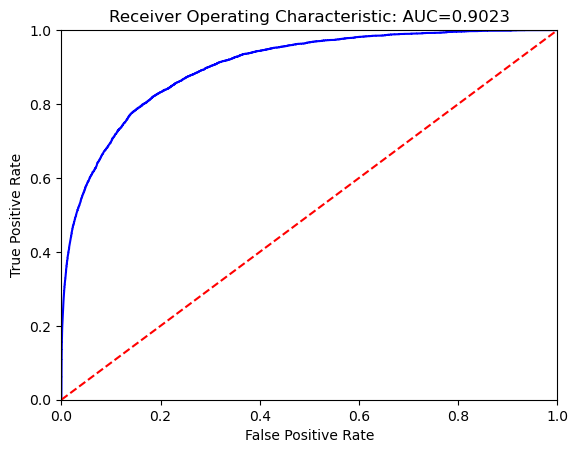

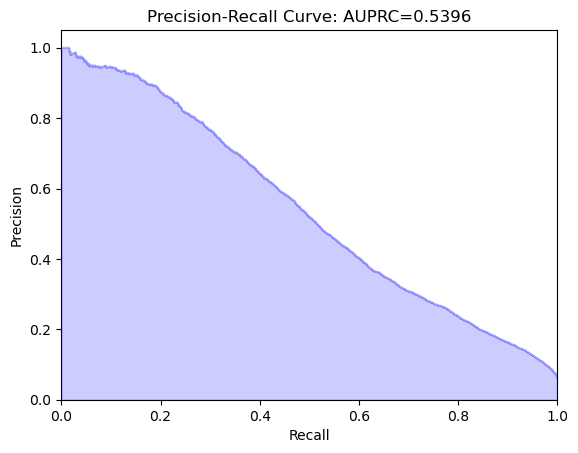

In [15]:
print("MLP:")
print('Training time:', runtime, 'seconds')
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [ ]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


In [ ]:
get_score_performance("score_NEWS", random_seed=random_seed)

In [ ]:
get_score_performance("score_NEWS2", random_seed=random_seed)

In [ ]:
get_score_performance("score_REMS", random_seed=random_seed)

In [ ]:
get_score_performance("score_MEWS", random_seed=random_seed)

### 4. Performance output

In [16]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task2.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.064,0.884 (0.882-0.886),0.437 (0.426-0.447),0.806 (0.797-0.817),0.797 (0.785-0.809),5.572
1,RF,0.080,0.893 (0.89-0.895),0.519 (0.51-0.527),0.8 (0.793-0.808),0.825 (0.822-0.827),99.886
2,GB,0.063,0.901 (0.898-0.903),0.543 (0.534-0.551),0.814 (0.804-0.826),0.823 (0.812-0.832),104.985
3,MLP,0.086,0.902 (0.9-0.905),0.54 (0.529-0.548),0.821 (0.801-0.83),0.815 (0.809-0.837),83.563


In [17]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
10,n_icu_365d,0.094003
0,age,0.093344
15,triage_sbp,0.089646
12,triage_heartrate,0.084737
18,triage_acuity,0.079927
16,triage_dbp,0.076983
11,triage_temperature,0.069906
13,triage_resprate,0.048931
14,triage_o2sat,0.045772
17,triage_pain,0.036784
